In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'USD'
share_name = 'YAR.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,3847,-2915,932,265,783,1479,2375,5257,0,...,0,0,613,2964,943,5585,149,-300,275.0,2014-10-25
1,2014-12-31,3770,-2758,1012,294,481,1619,2495,5162,0,...,0,0,643,2902,1420,6406,227,-386,275.0,2015-02-09
2,2015-03-31,3570,-2550,1020,109,494,1691,2335,5002,0,...,0,0,376,2633,1235,5872,698,-260,274.0,2015-04-25
3,2015-06-30,3578,-2602,976,388,377,1624,2488,5171,0,...,0,0,492,2788,1221,5900,481,-244,274.0,2015-07-25
4,2015-09-30,3301,-2454,847,499,1005,1405,2280,5289,0,...,0,0,474,2623,1084,5539,535,-305,274.0,2015-10-25


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-10-25,254.00,3850,-3054,796,2,868,1710,2794,...,129,15665,0,141,160,3515,3518,8523,1015,-299
37,2023-12-31,2024-02-09,254.00,3582,-2473,1109,246,539,1634,3058,...,135,16027,0,517,123,3714,3284,8457,93,-373
38,2024-03-31,2024-04-22,254.73,3315,-2447,868,16,328,1883,2841,...,134,15660,1818,424,140,3520,3238,8238,58,-260
39,2024-06-30,2024-07-15,254.73,3529,-2525,1004,3,872,1720,2802,...,137,15948,2001,494,136,3699,3486,8675,822,-249
40,2024-09-30,2024-10-21,254.73,3654,-2766,888,286,907,1637,3026,...,144,16373,1951,498,140,3589,3519,8685,311,-258


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-25,254.00,3850,-3054,796,2,868,1710,2794,...,15665,0,141,160,3515,3518,8523,1015,-299,10.483742
37,2023-12-31,2024-02-09,254.00,3582,-2473,1109,246,539,1634,3058,...,16027,0,517,123,3714,3284,8457,93,-373,10.821103
38,2024-03-31,2024-04-22,254.73,3315,-2447,868,16,328,1883,2841,...,15660,1818,424,140,3520,3238,8238,58,-260,10.502364
39,2024-06-30,2024-07-15,254.73,3529,-2525,1004,3,872,1720,2802,...,15948,2001,494,136,3699,3486,8675,822,-249,10.750878
40,2024-09-30,2024-10-21,254.73,3654,-2766,888,286,907,1637,3026,...,16373,1951,498,140,3589,3519,8685,311,-258,10.704589


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-25,254.00,40362.406850,-32017.348187,8345.058663,20.967484,9099.888090,17927.198887,29291.575257,...,164227.819041,0.000000,1478.207628,1677.398726,36850.353267,36881.804493,89352.933399,10640.998170,-3134.638870,10.483742
37,2023-12-31,2024-02-09,254.00,38761.190764,-26760.587594,12000.603171,2661.991326,5832.574490,17681.682219,33090.932819,...,173429.816968,0.000000,5594.510225,1330.995663,40189.576354,35536.502085,91514.067642,1006.362574,-4036.271400,10.821103
38,2024-03-31,2024-04-22,254.73,34815.336213,-25699.284378,9116.051835,168.037822,3444.775348,19775.951158,29837.215741,...,164467.018129,19093.297507,4453.002279,1470.330941,36968.320805,34006.654195,86518.473521,609.137104,-2730.614605,10.502364
39,2024-06-30,2024-07-15,254.73,37939.848398,-27145.966904,10793.881494,32.252634,9374.765600,18491.510129,30123.960105,...,171455.002056,21512.506842,5310.933723,1462.119406,39767.497655,37477.560645,93263.866493,8837.221701,-2676.968617,10.750878
40,2024-09-30,2024-10-21,254.73,39114.567151,-29608.892375,9505.674776,3061.512371,9709.061961,17523.411720,32392.085440,...,175266.230969,20884.652576,5330.885178,1498.642420,38418.768885,37669.447675,92969.352957,3329.127089,-2761.783888,10.704589


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data
## Pull historical share prices

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-10-27,169.310455,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.612072,0.387928,0.0,0.0,0.0,0.0,0.242267,0.068885,0.0,0.0
1,2014-11-03,172.754593,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.612072,0.387928,0.0,0.0,0.0,0.0,0.242267,0.068885,0.0,0.0
2,2014-11-10,171.333176,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.612072,0.387928,0.0,0.0,0.0,0.0,0.242267,0.068885,0.0,0.0
3,2014-11-17,174.777344,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.612072,0.387928,0.0,0.0,0.0,0.0,0.242267,0.068885,0.0,0.0
4,2014-11-24,163.078140,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.612072,0.387928,0.0,0.0,0.0,0.0,0.242267,0.068885,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-10-27,169.310455,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.0,0.242267,0.068885,0.0,0.0,inf,0.846717,inf,inf,inf
1,2014-11-03,172.754593,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.0,0.242267,0.068885,0.0,0.0,inf,0.863941,inf,inf,inf
2,2014-11-10,171.333176,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.0,0.242267,0.068885,0.0,0.0,inf,0.856833,inf,inf,inf
3,2014-11-17,174.777344,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.0,0.242267,0.068885,0.0,0.0,inf,0.874057,inf,inf,inf
4,2014-11-24,163.078140,2014-09-30,24006.336102,0.0,199.961088,275.0,0.0,0.0,4886.134954,...,0.0,0.242267,0.068885,0.0,0.0,inf,0.815549,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

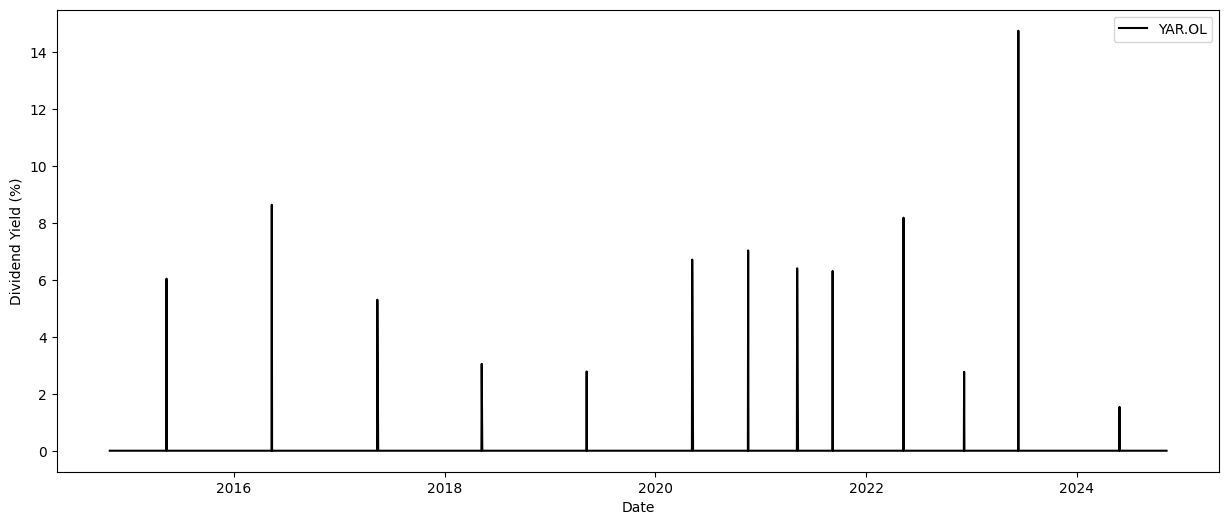

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.701384
share_price      1.000000
Name: share_price, dtype: float64


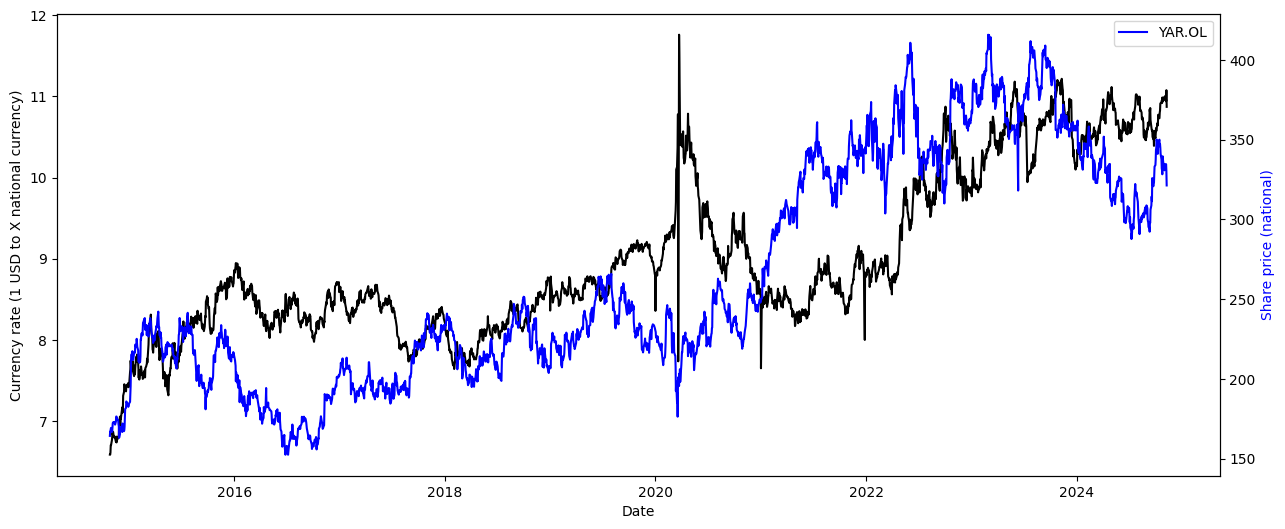

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

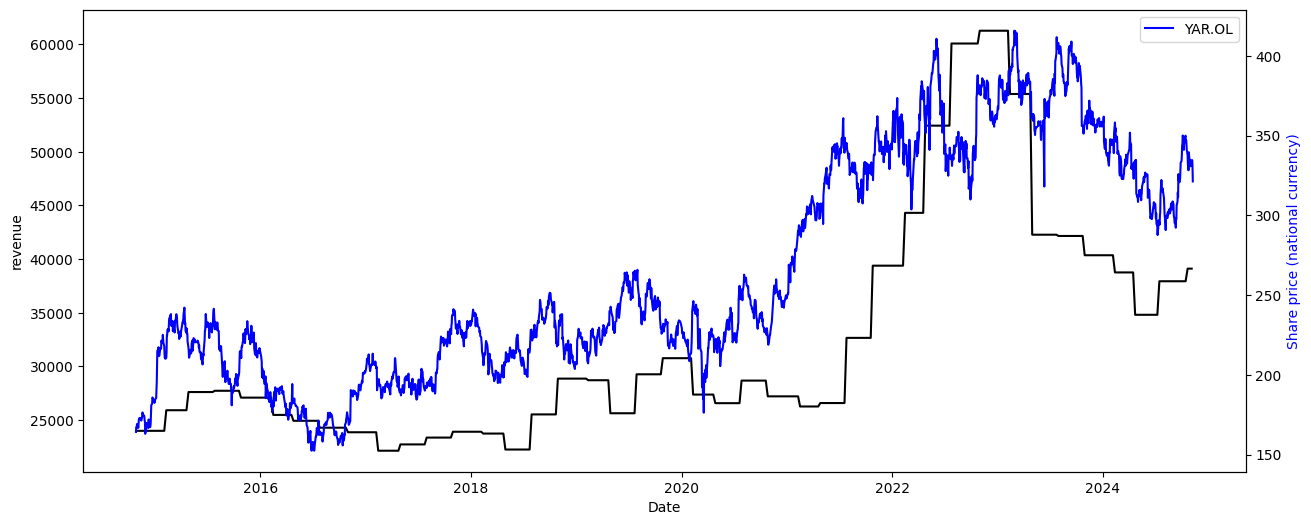

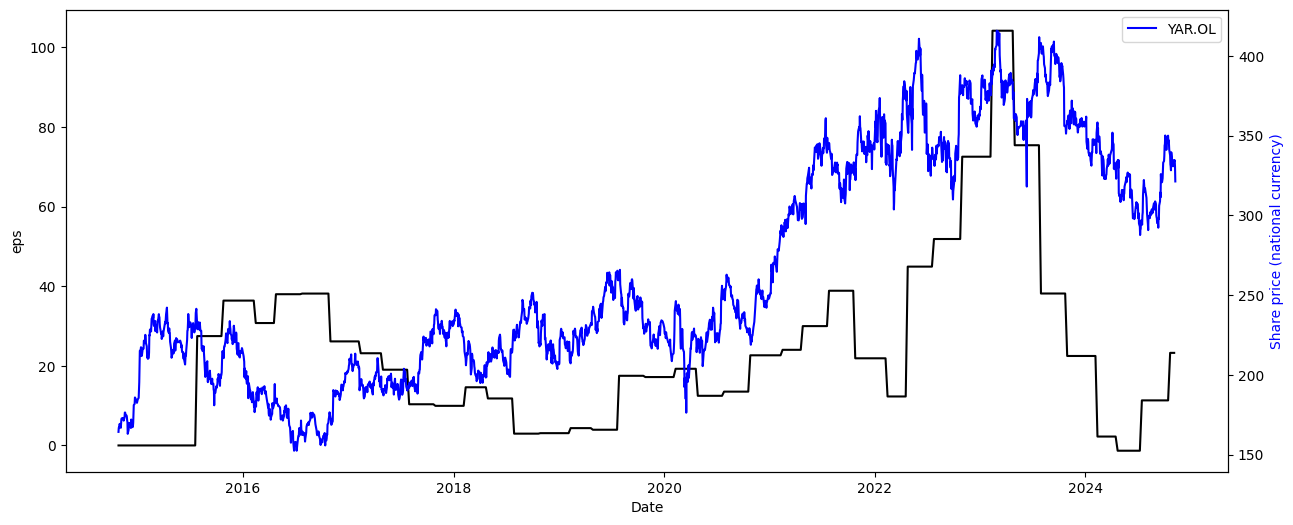

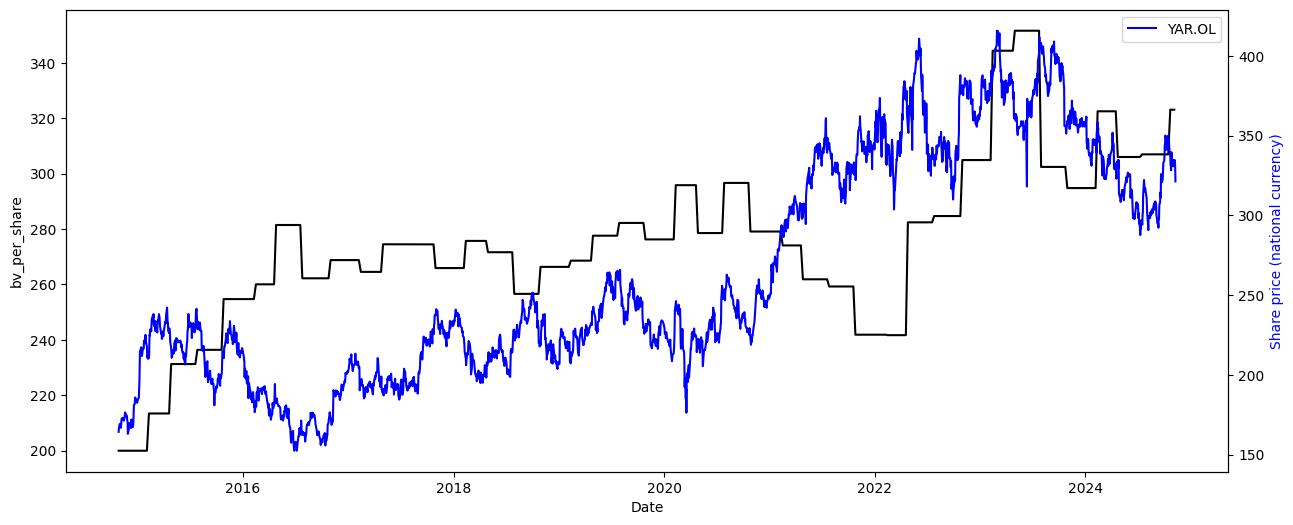

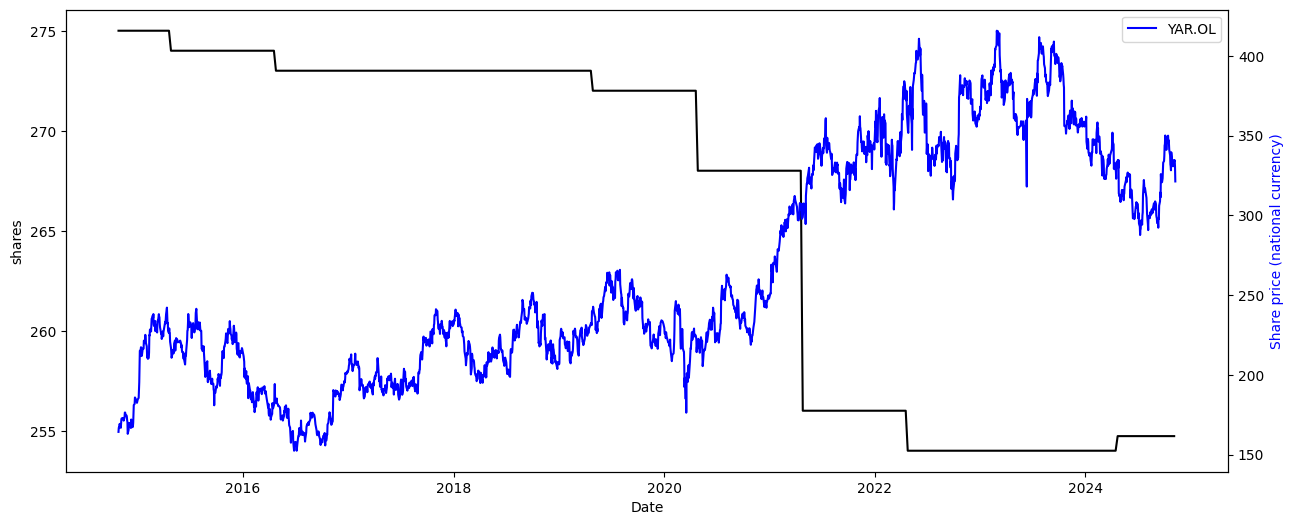

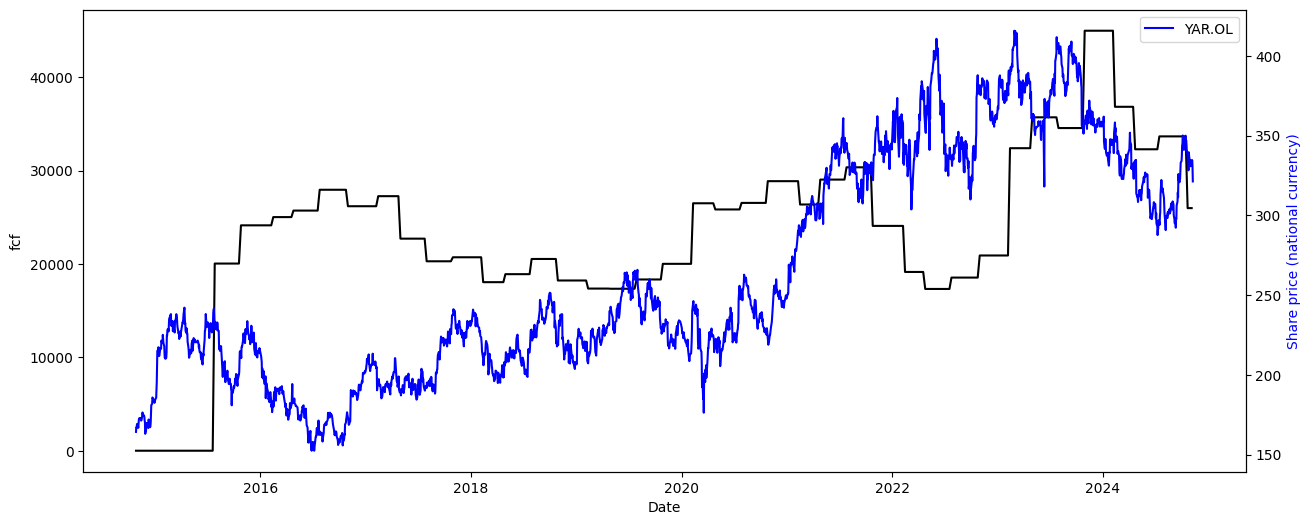

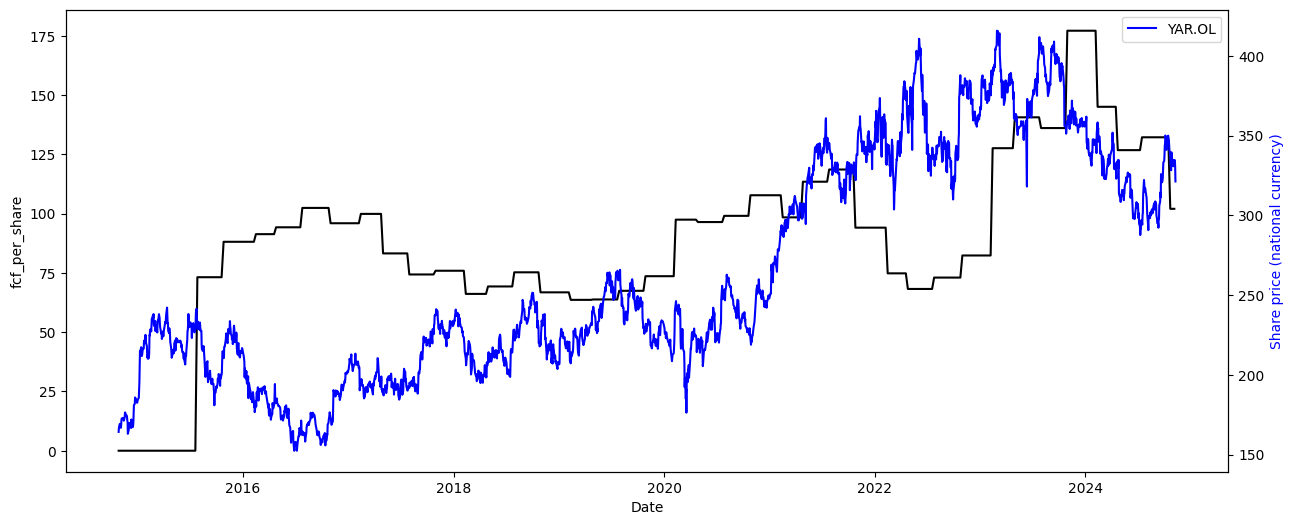

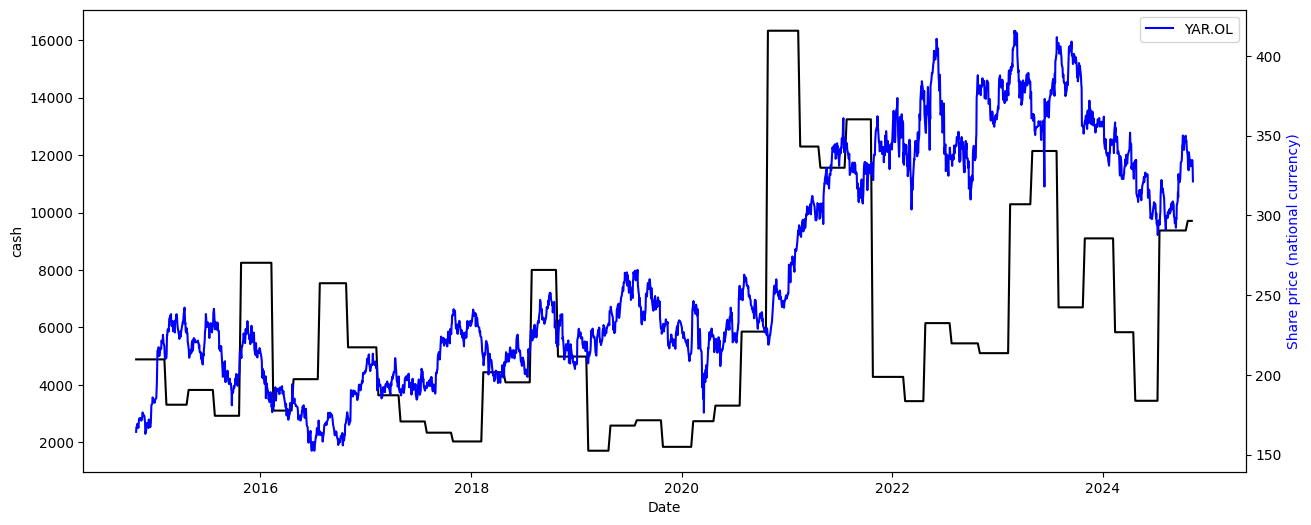

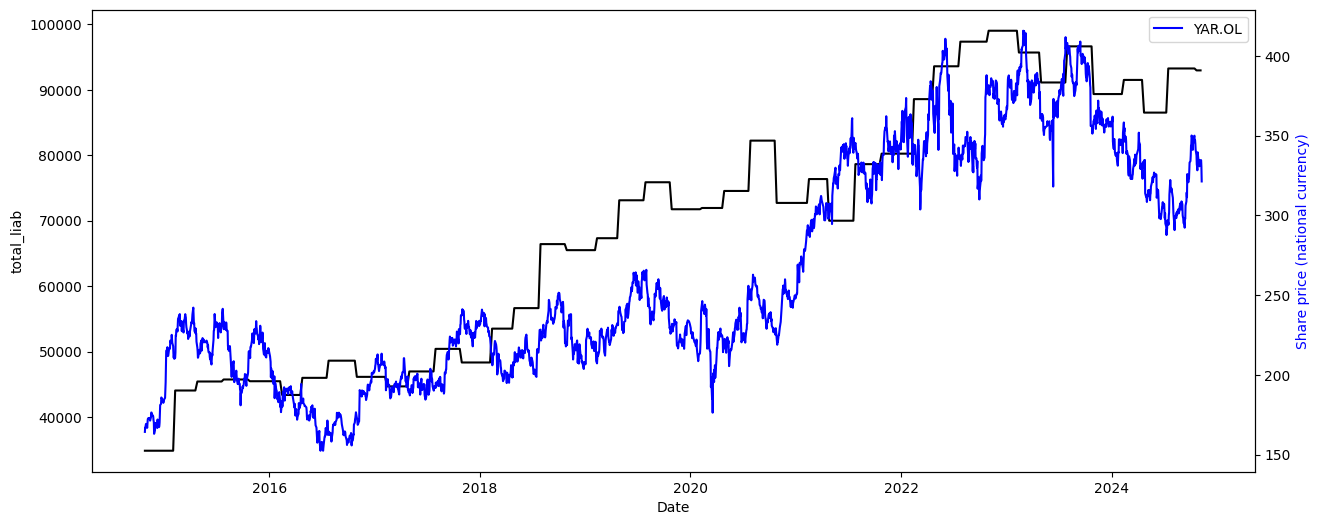

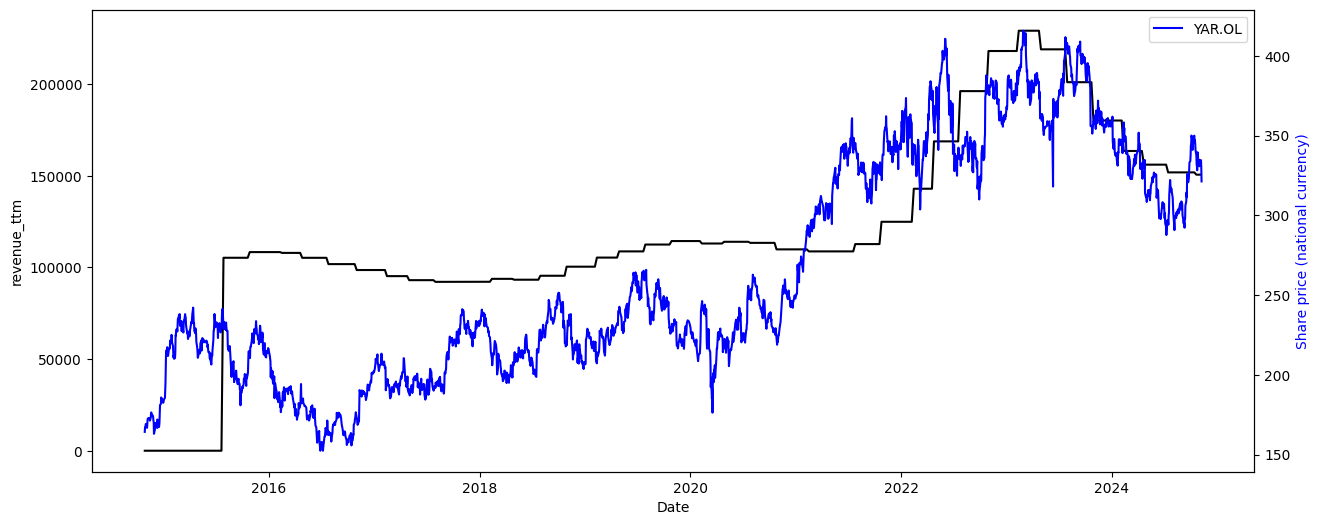

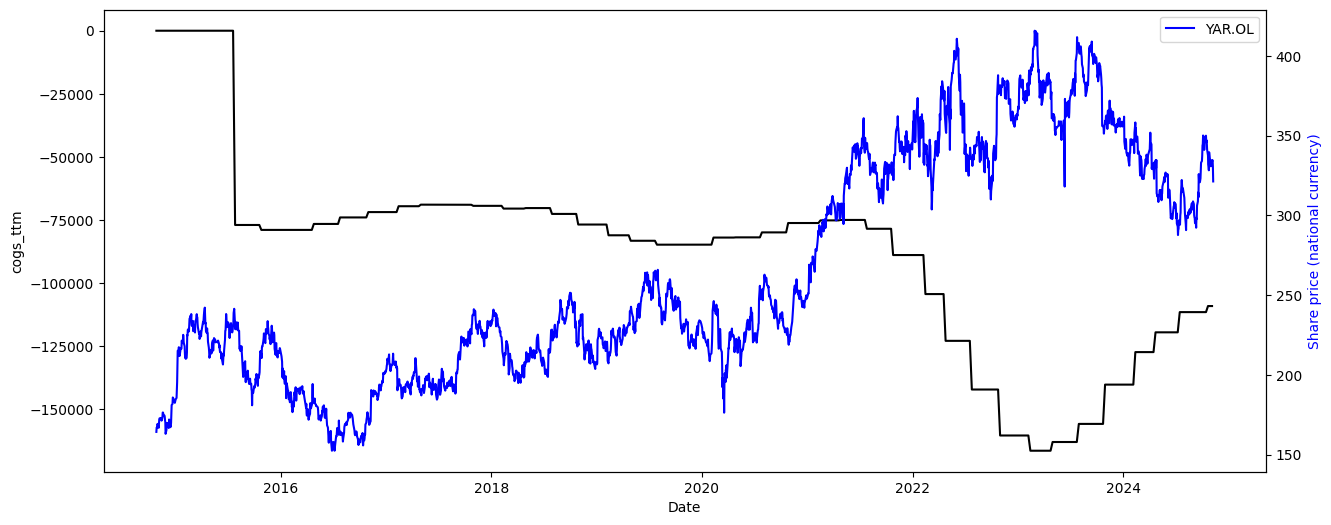

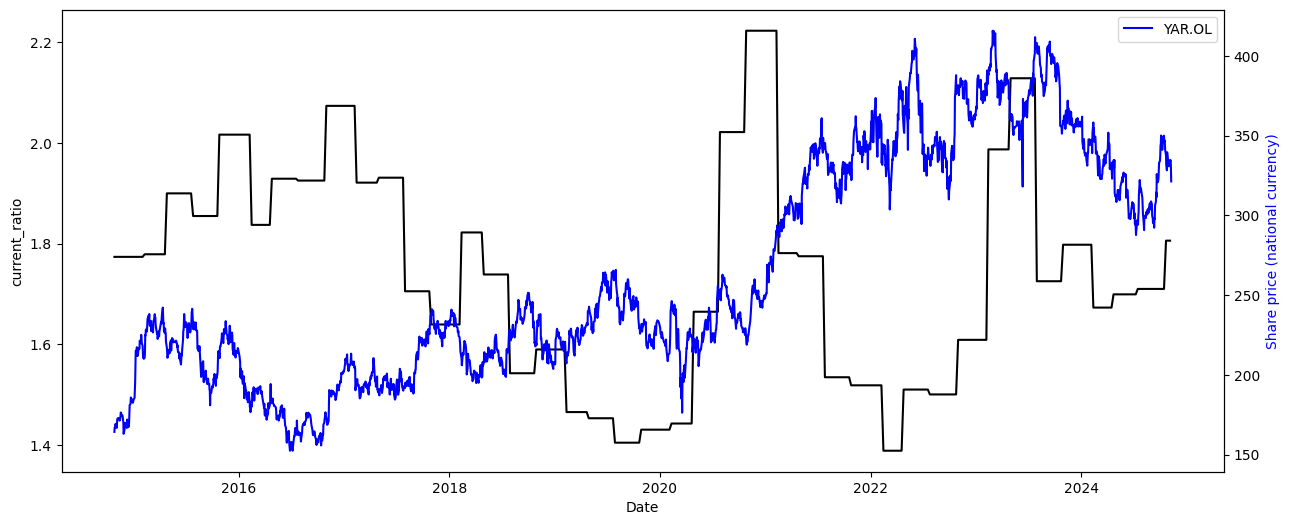

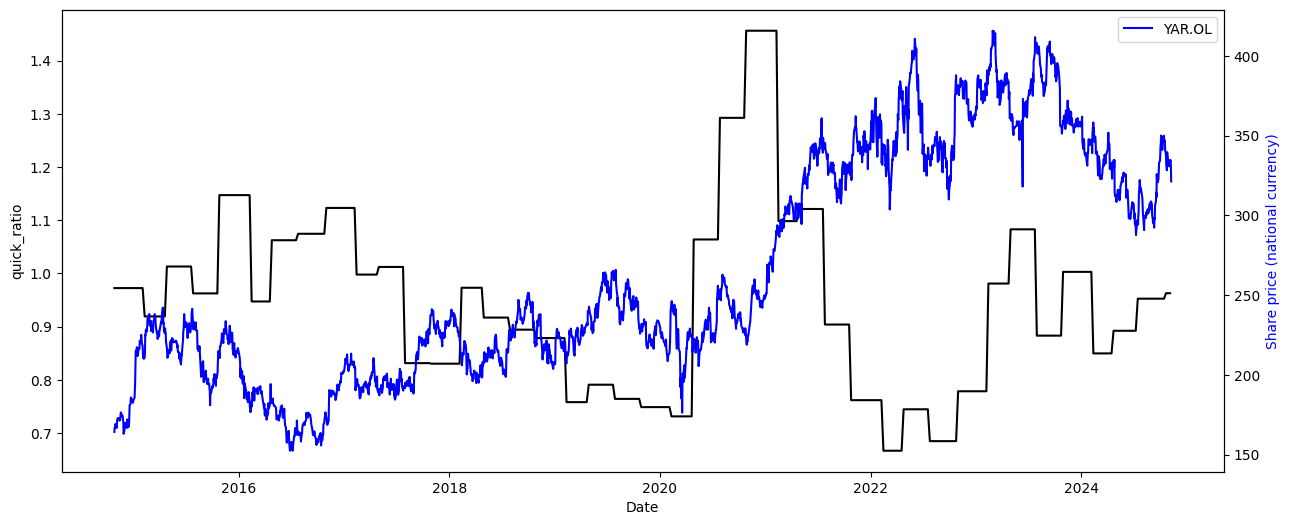

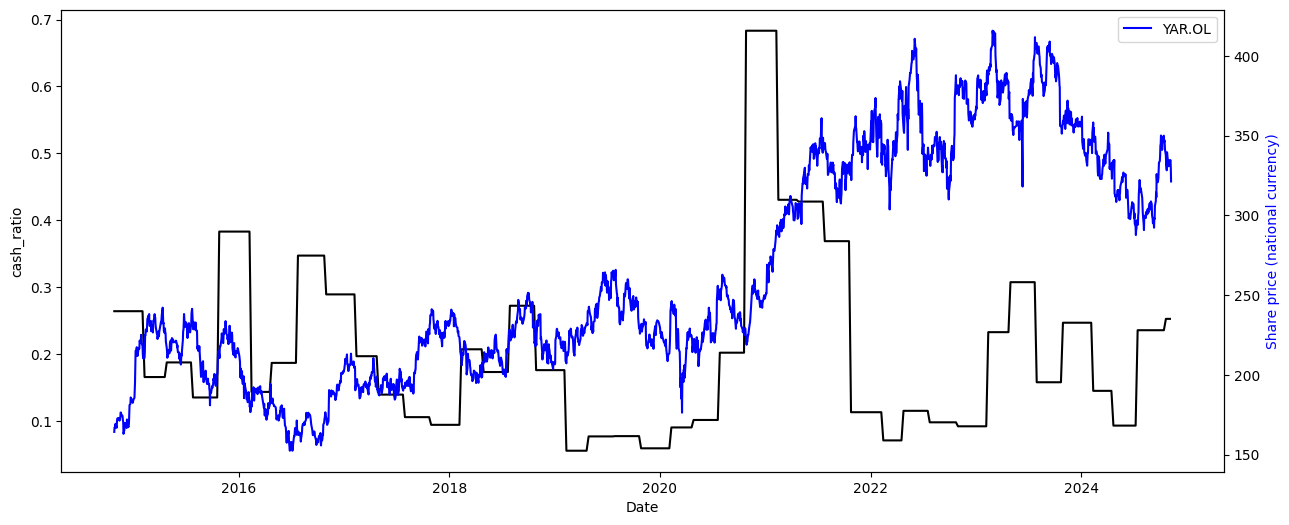

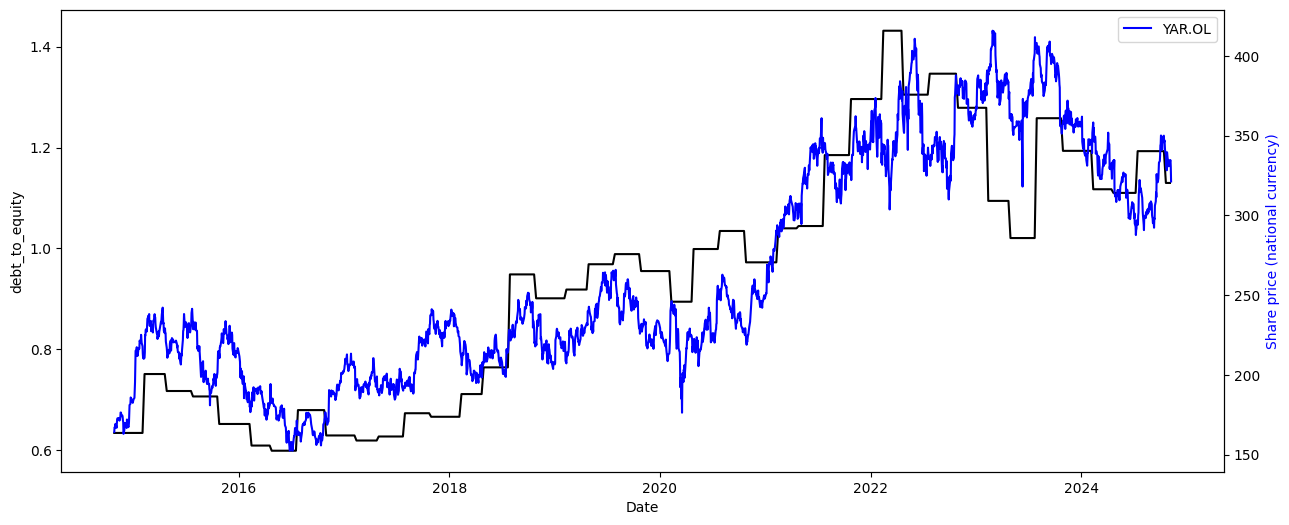

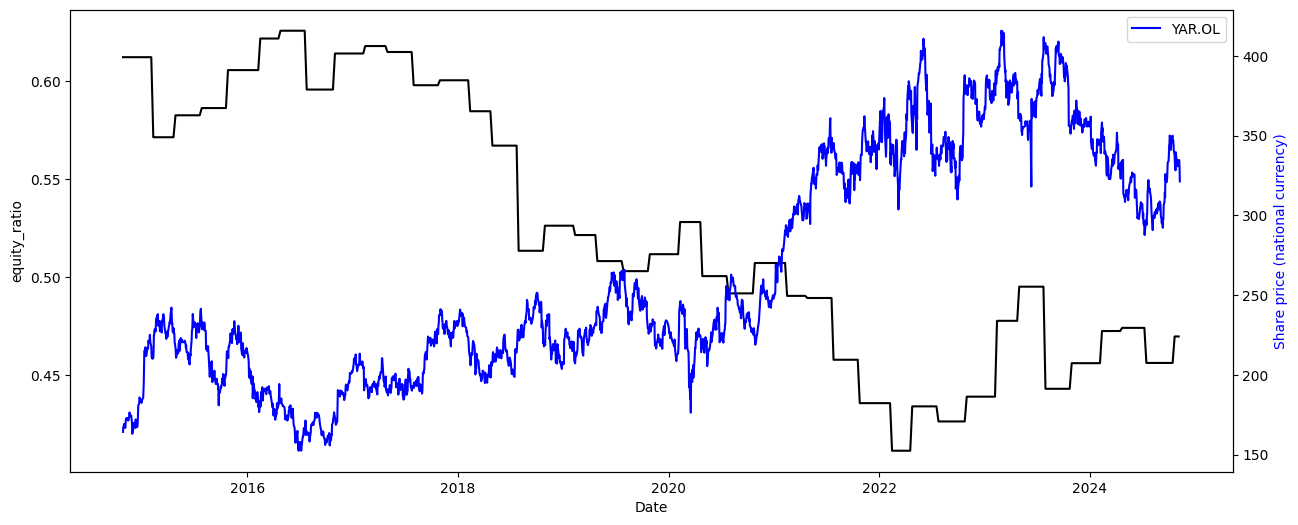

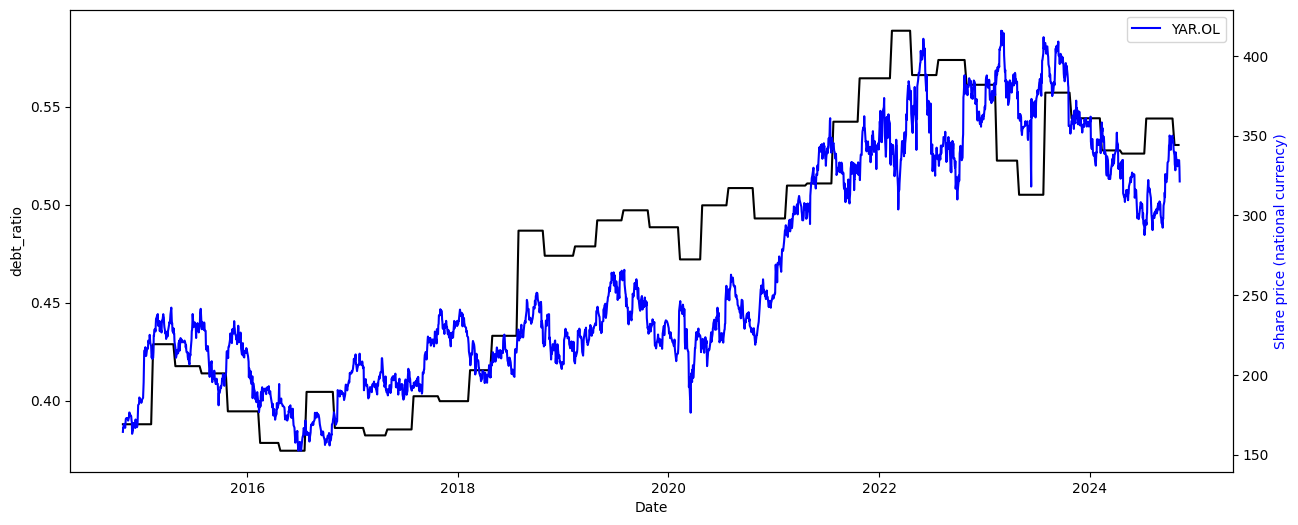

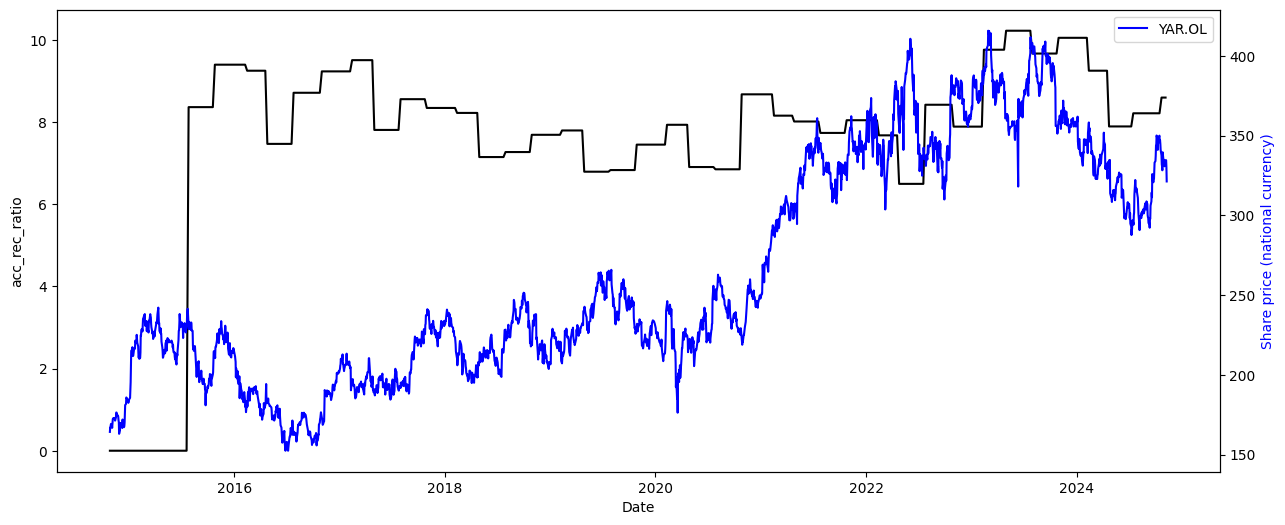

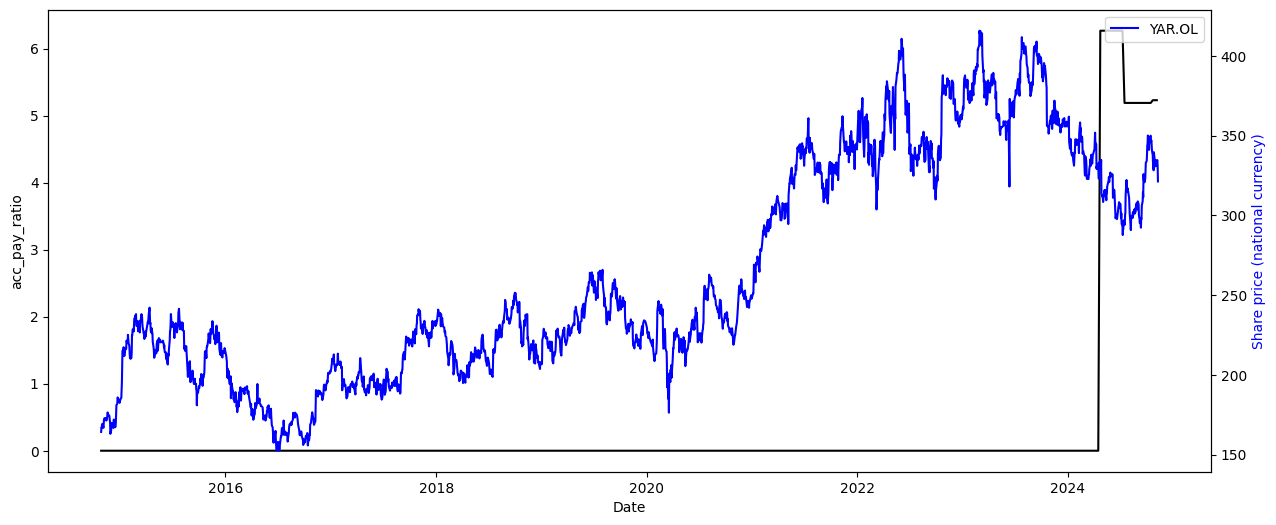

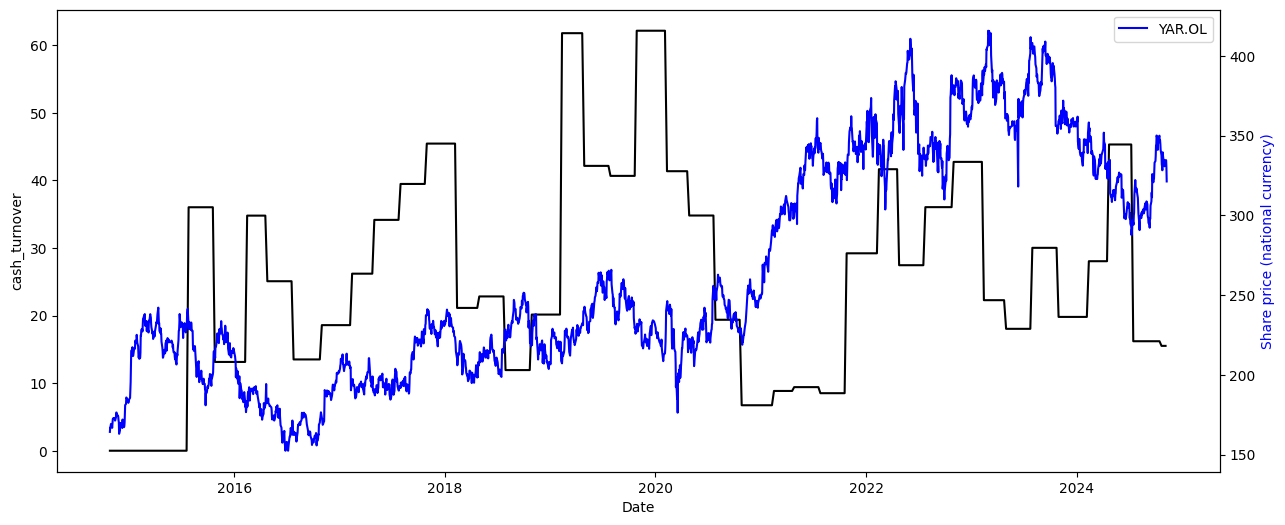

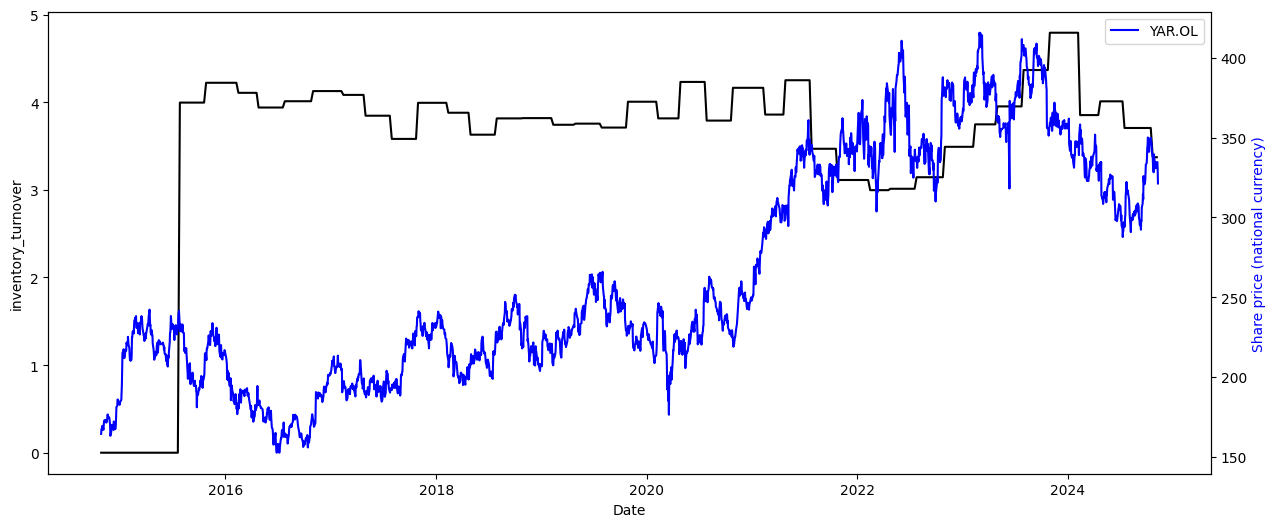

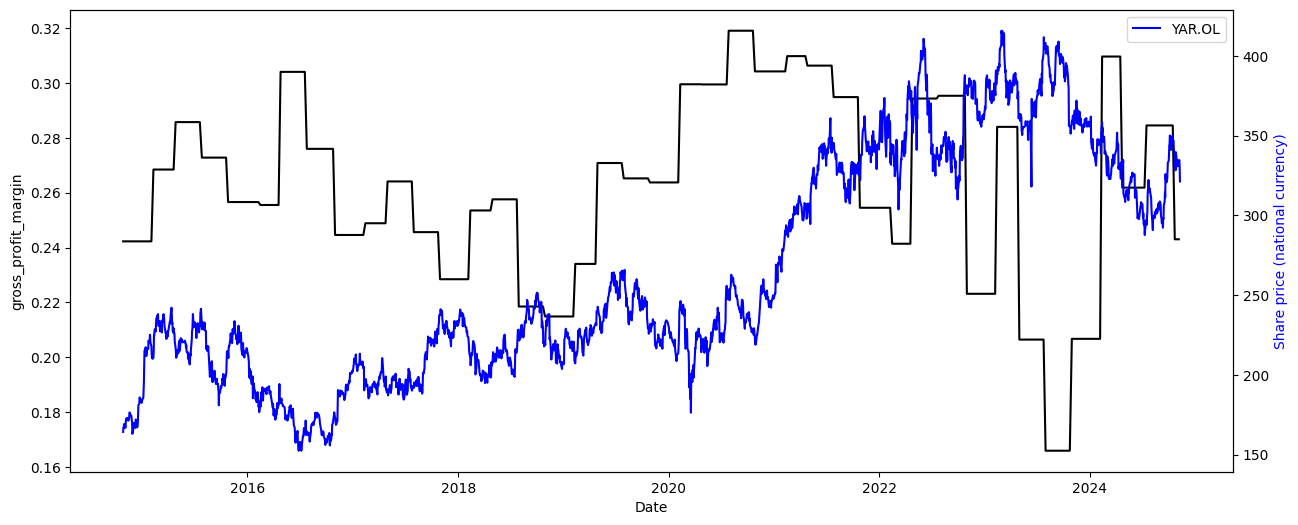

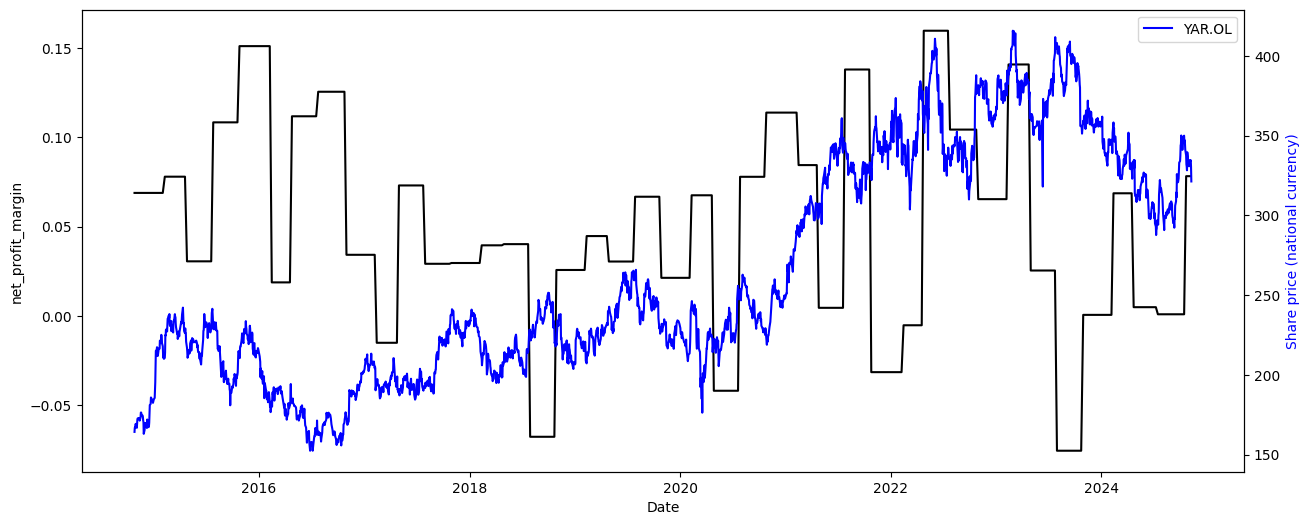

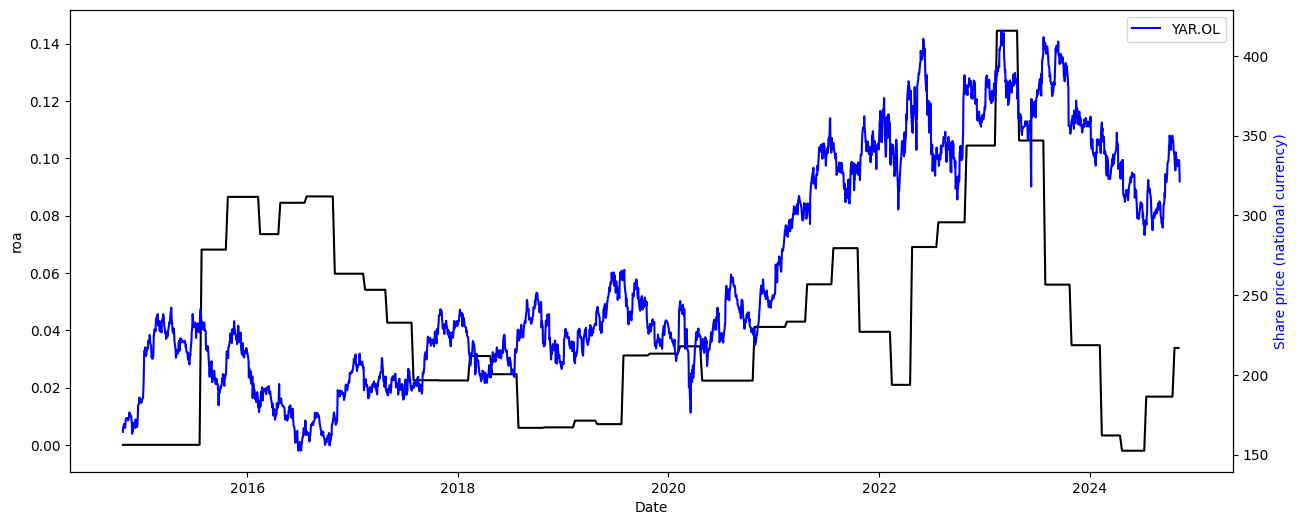

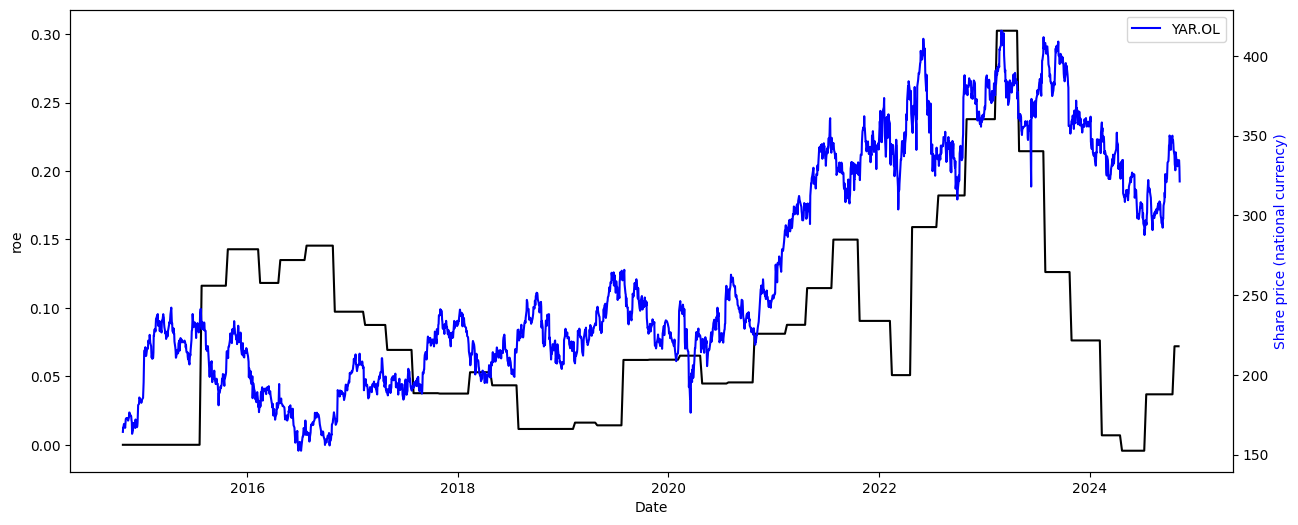

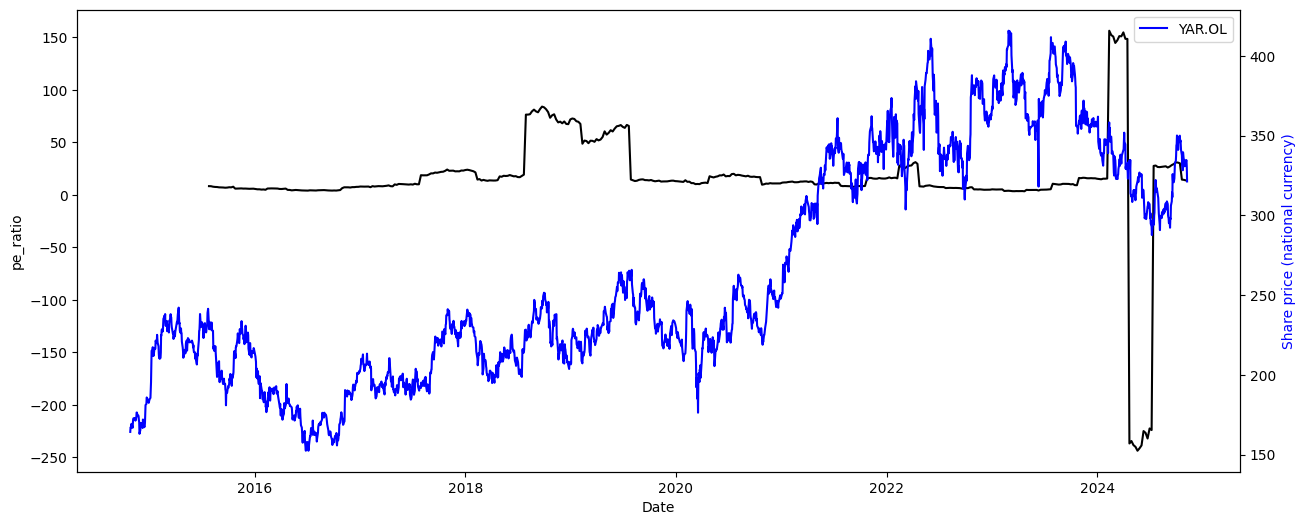

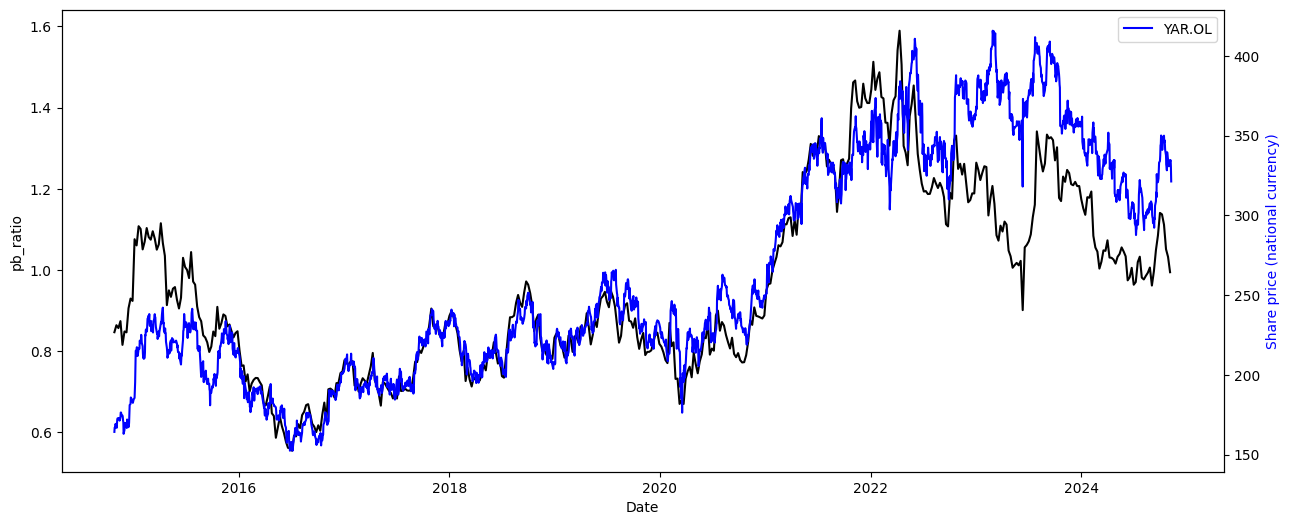

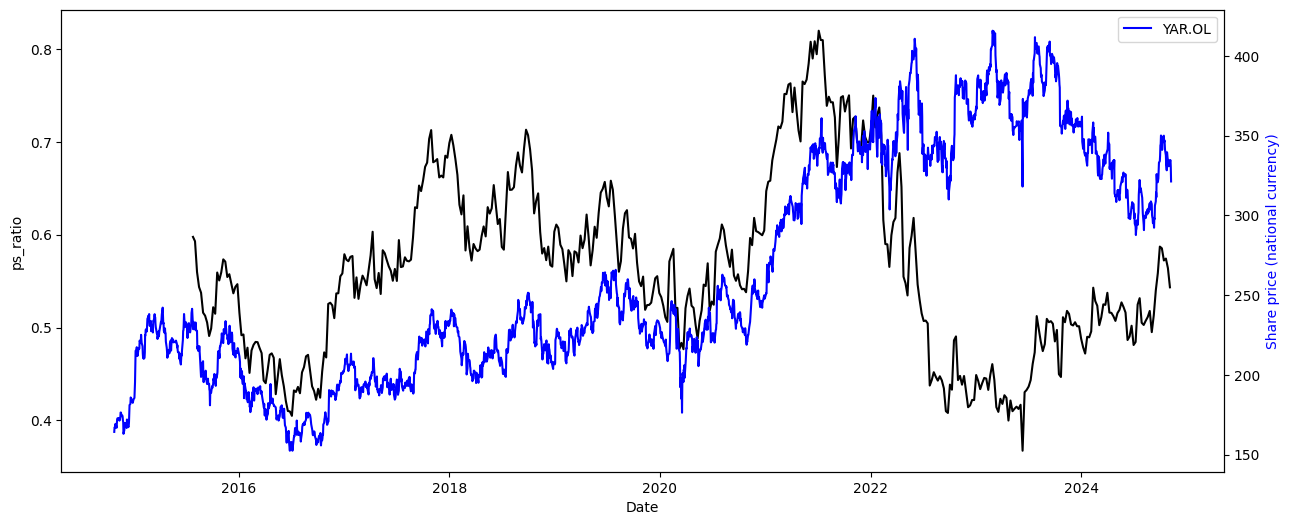

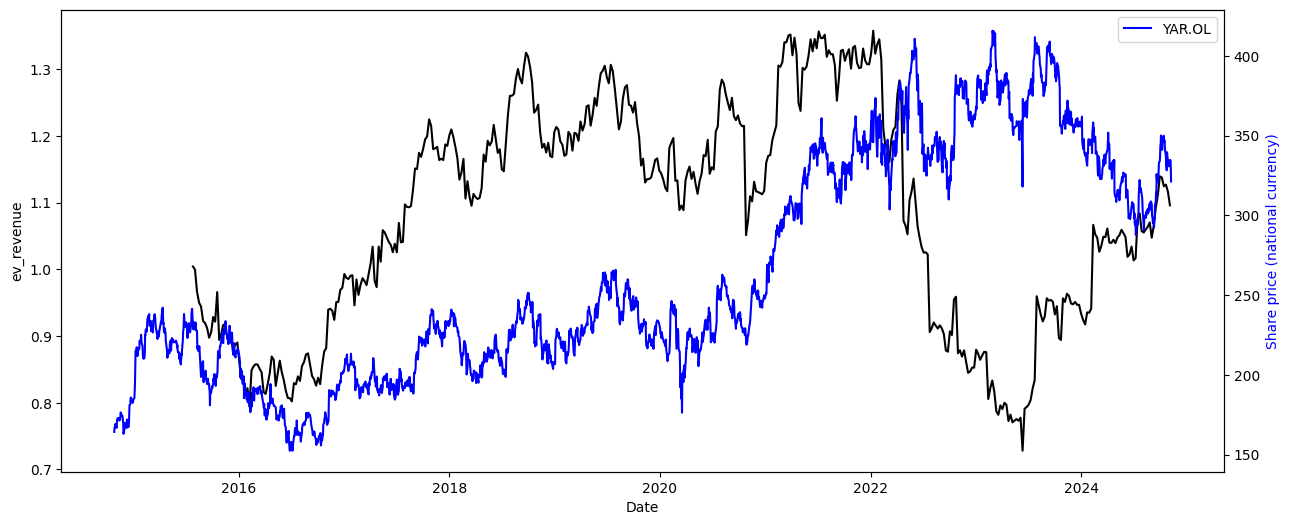

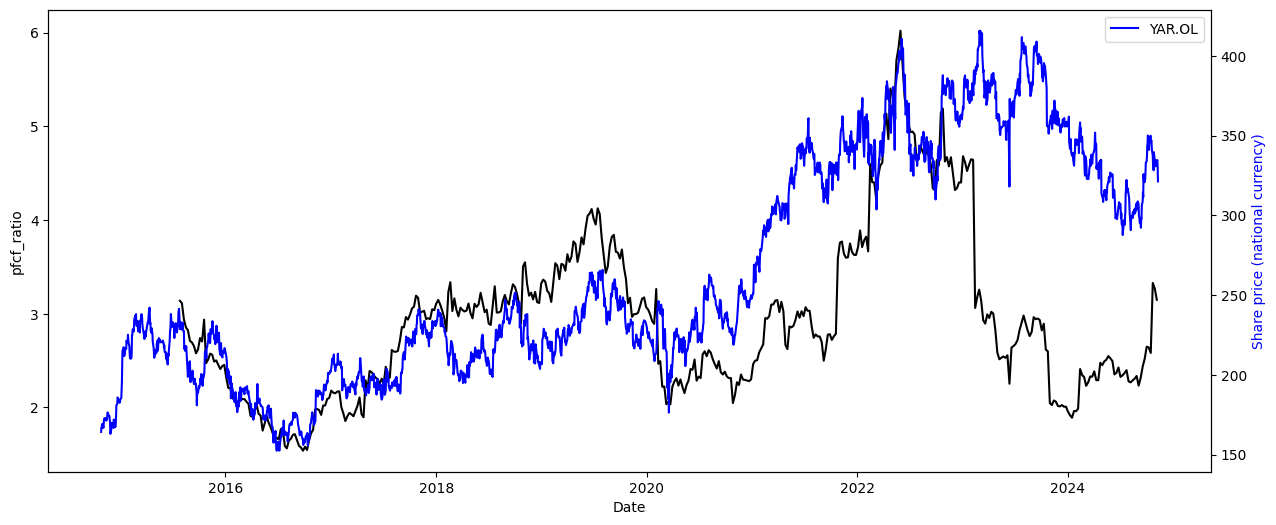

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

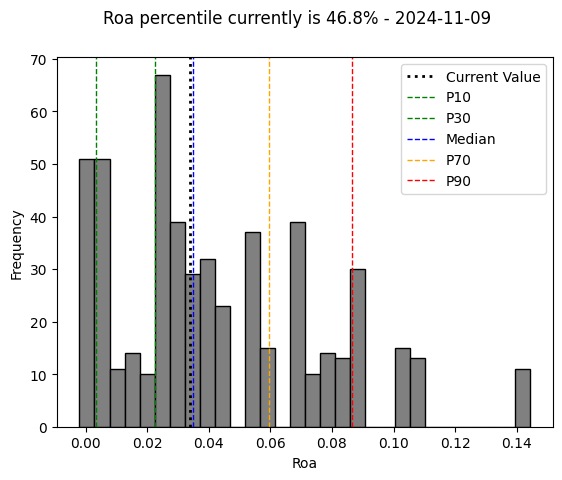

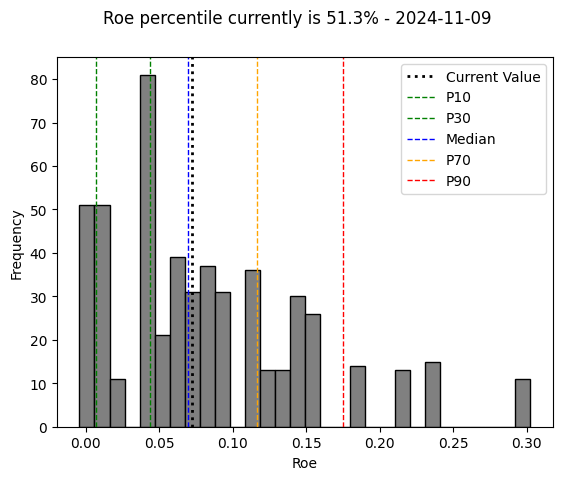

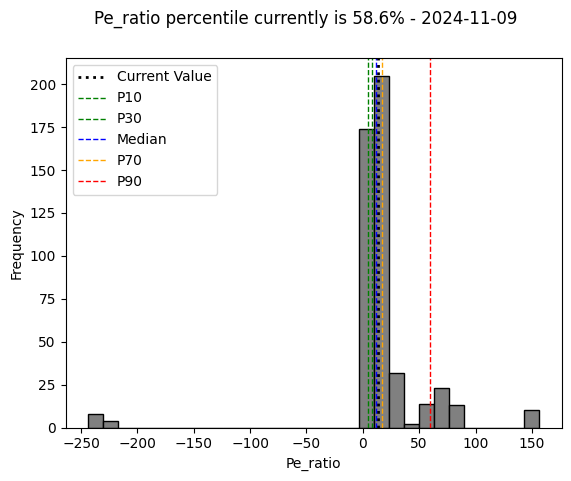

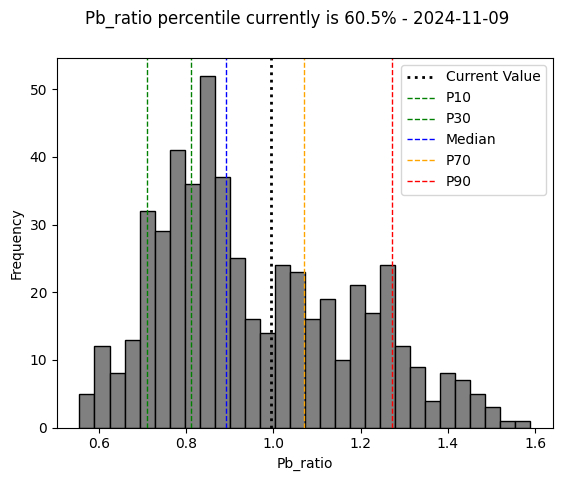

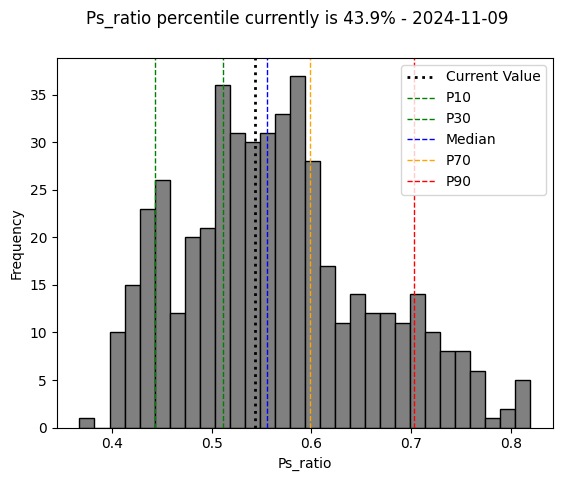

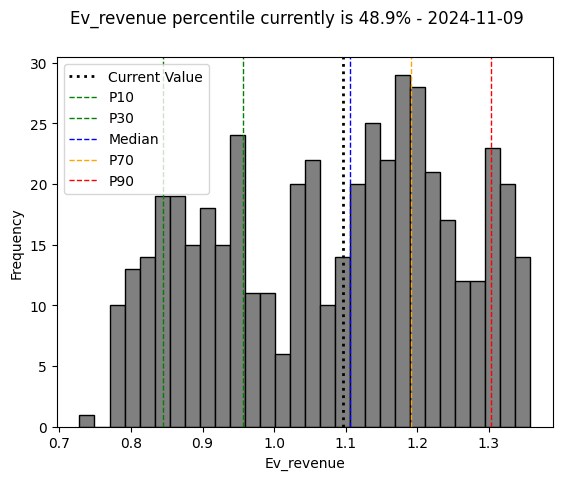

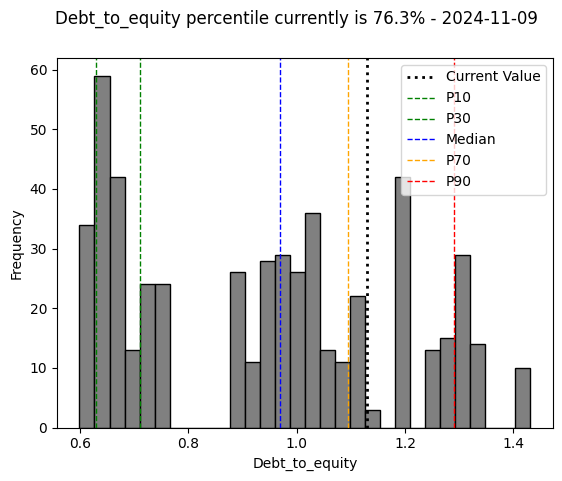

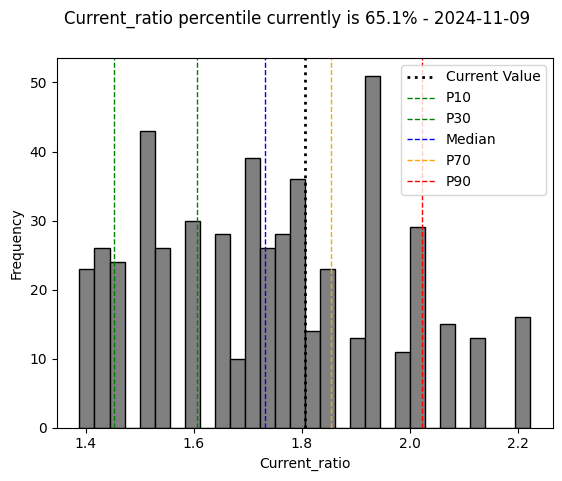

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.977421,-0.129112,0.105635,-0.467806,-0.689450,0.086760,0.347653
roe,0.977421,1.000000,-0.119641,0.268582,-0.437962,-0.617904,0.265065,0.240310
pe_ratio,-0.129112,-0.119641,1.000000,-0.036539,0.188336,0.216484,-0.029588,-0.155663
pb_ratio,0.105635,0.268582,-0.036539,1.000000,0.252292,0.200293,0.819391,-0.327122
ps_ratio,-0.467806,-0.437962,0.188336,0.252292,1.000000,0.886170,0.030742,-0.252015
ev_revenue,-0.689450,-0.617904,0.216484,0.200293,0.886170,1.000000,0.198015,-0.494170
debt_to_equity,0.086760,0.265065,-0.029588,0.819391,0.030742,0.198015,1.000000,-0.452936
current_ratio,0.347653,0.240310,-0.155663,-0.327122,-0.252015,-0.494170,-0.452936,1.000000


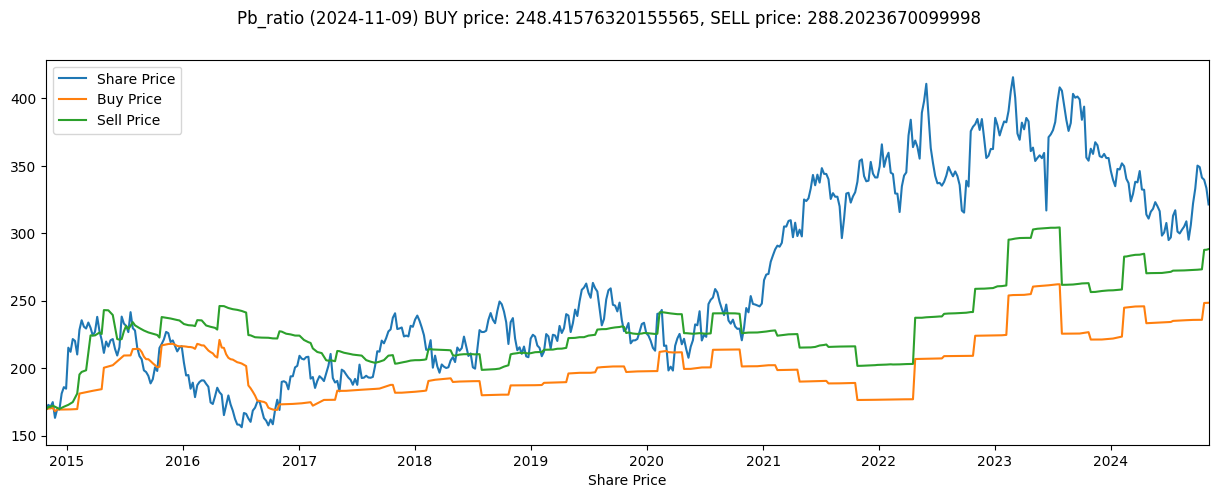

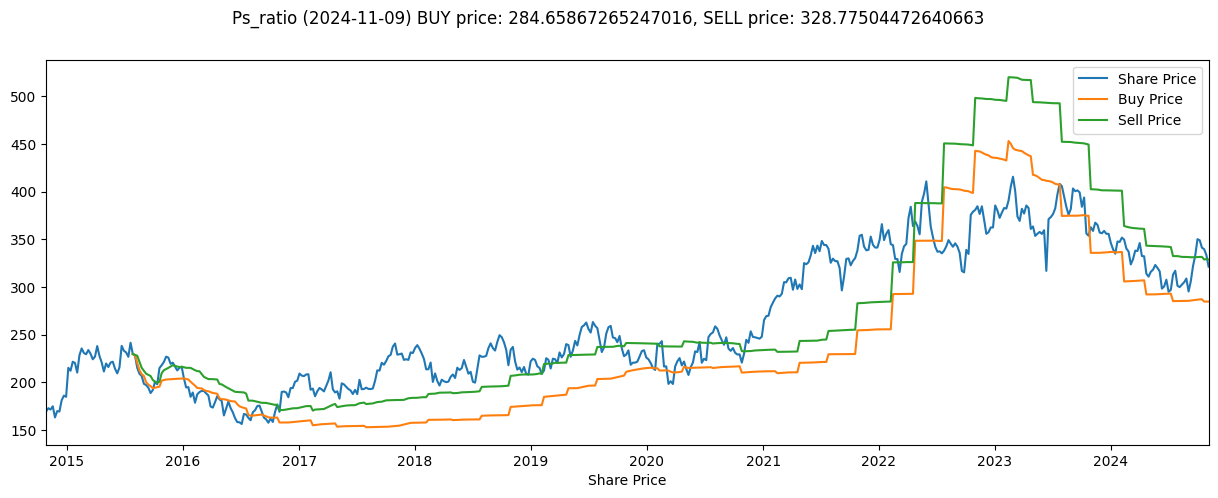

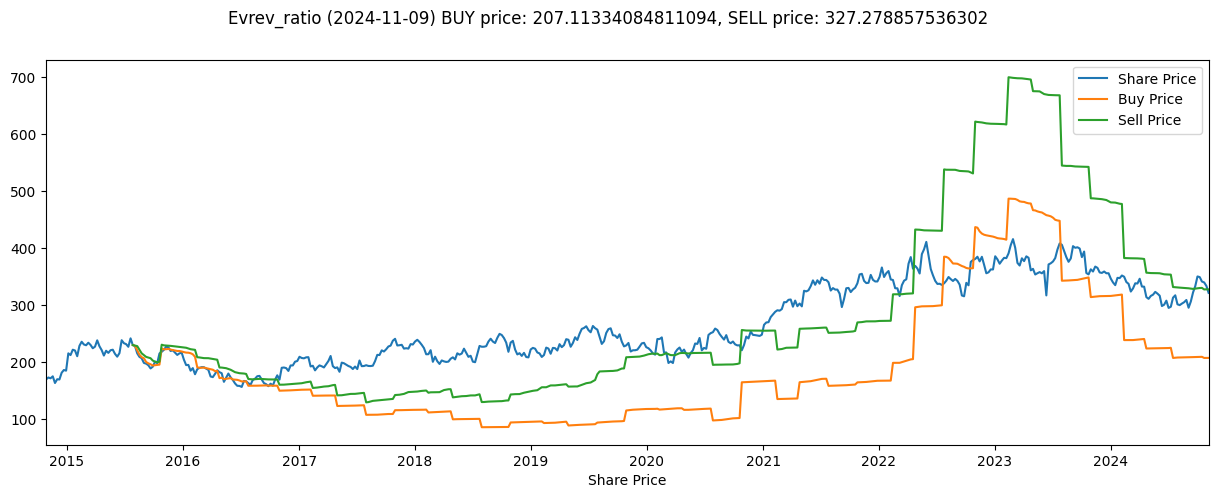

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)